# OpenMP Parallel Performance and Scalability analysis of $n$-body problem
---

Import all the required libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML

## System Info
---

In [2]:
base_path = 'data/'

info = pd.read_csv(base_path + 'system_info.txt', ':', names = ["Parameter", "Description"])
info = pd.DataFrame(info, columns = ["Parameter", "Description"])
display(HTML(info.to_html(justify='left',bold_rows=True ,index=False)))

Parameter,Description
OS,macOS
Processor Vendor,GenuineIntel
Processor Name/Speed,Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Total Number of Cores,2
Memory Size (MB),4096


## Obtain the data
---

Serial and parallel execution times can be obtained by running the script *run_tests.sh*. The number of processors, $N$, can be specified in the OpenMP parallelization.

> $ ./run_tests simpar

> $ ./run_tests simpar-omp N

The results from each run is stored in a csv file e.g ***parallel_cpu4_results.csv*** where the tests where run for $N=4$.

Read data from csv files and create DataFrame objects for each of the files. Since serial and parallel results for each number of processors are divided in different files, we concatenate the data from all the parallel results.

In [3]:
serial = pd.read_csv(base_path + 'serial_cpu1_results.csv')
serial.insert(0, column='Test Number', value=serial.index)

num_procs = 8
parallel_data = []

for i in range(1, num_procs+1):
    filename = 'parallel_cpu' + str(i) + '_results.csv'
    
    try:
        parallel_data.append(pd.read_csv(base_path + filename))
    except:
        print('File {0} not found. Try running the test script for {1} threads'.format(filename,i))

parallel = pd.concat(parallel_data, ignore_index=False)
parallel.insert(0, column='Test Number', value=parallel.index)

## Display data
---

### Serial algorithm results

In [4]:
display(HTML(serial.to_html(index=False)))

Test Number,Seed,Grid size,Particles,Steps,Processors,Real time,User time,System time,CPU percentage,Label,Correctness
0,1,3,10,2,1,0.011,0.002,0.003,42.15,serial,SUCCESS
1,3,10,100,5,1,0.005,0.001,0.002,61.35,serial,FAILURE
2,3,5,500,5,1,0.006,0.002,0.002,64.17,serial,SUCCESS
3,2,5,10000,10,1,0.016,0.012,0.002,85.79,serial,SUCCESS
4,4,20,100000,5,1,0.067,0.057,0.006,93.84,serial,SUCCESS
5,8,5,1000000,50,1,4.705,4.657,0.036,99.74,serial,SUCCESS


### OpenMP algorithm results

In [5]:
display(HTML(parallel.sort_values(by=['Test Number','Processors']).to_html(index=False)))

Test Number,Seed,Grid size,Particles,Steps,Processors,Real time,User time,System time,CPU percentage,Label,Correctness
0,1,3,10,2,1,0.009,0.002,0.002,45.91,parallel,SUCCESS
0,1,3,10,2,2,0.006,0.002,0.002,63.09,parallel,SUCCESS
0,1,3,10,2,3,0.008,0.003,0.002,60.41,parallel,SUCCESS
0,1,3,10,2,4,0.008,0.002,0.003,69.90,parallel,SUCCESS
0,1,3,10,2,5,0.011,0.002,0.003,43.48,parallel,SUCCESS
0,1,3,10,2,6,0.009,0.003,0.004,77.78,parallel,SUCCESS
0,1,3,10,2,7,0.008,0.002,0.002,57.58,parallel,SUCCESS
0,1,3,10,2,8,0.006,0.002,0.002,71.33,parallel,SUCCESS
1,3,10,100,5,1,0.005,0.002,0.002,62.87,parallel,FAILURE
1,3,10,100,5,2,0.007,0.002,0.002,65.47,parallel,FAILURE


## Calculate performance metrics
---

Performance results for the faculty provided tests, with varying number of particles, $n$, and simulation steps, $t$. The performance metric used to check scalability was the elapsed time, the speedup and efficiency.

In [6]:
# Set indexes for data frames
serial.set_index(['Test Number'], inplace=True)
parallel.set_index(['Test Number','Processors'], inplace=True)

### Speedup

The principal measure of parallelization efficiency is the speedup, $S$, defined to be the ratio of the time to execute the computational workload $W$ on a single processor to the time on $N$ processors.
    
\begin{equation}
    S_N = \frac{T_1}{T_N}
    \quad\text{where}\quad
    T_N = (f + \frac{(1-f)}{N})T_1
\end{equation}

$f$  represents the fraction of the code that cannot be parallelized. The remaining fraction, $1 – f$, is parallelizable. Optimally, if the parallelized code scales linearly with the number of processors once parallelized, then the runtime reduces to $\frac{(1-f)}{N}$.

In [7]:
parallel['Speedup'] = (serial['Real time'] / parallel['Real time'])

In [8]:
# Reset indexes in order to calculate the following metrics
serial.reset_index(inplace=True)
parallel.reset_index(inplace=True)

### Efficiency

The ratio of the true speedup to the theoretical speedup is the parallelization efficiency, which is a measure of the efficiency of the parallel processor to execute a given parallel algorithm. Any degradation in performance due to parallelization overhead will result in $\epsilon_N$ being less than one.

\begin{equation}
    \epsilon_N = \frac{Speedup(P)}{P}
\end{equation}

In [9]:
parallel['Efficiency'] = parallel['Speedup'] / parallel['Processors']

## Data analysis
---

In [10]:
aux = parallel[['Test Number','Particles', 'Steps','Processors','Real time','Speedup','Efficiency']]
temp = pd.DataFrame(aux)
temp.set_index(['Test Number','Processors'], inplace=True)
temp.sort_index(inplace=True)

display(HTML(temp.sort_values(by=['Test Number','Processors']).to_html(index=True)))

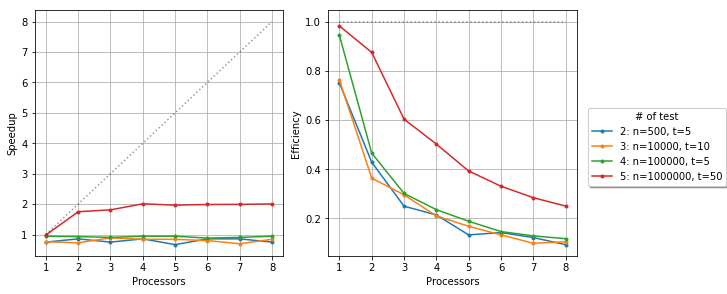

In [11]:
line_labels = []
lines = []

# Create matplotlib figure
fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.tight_layout()
fig.subplots_adjust(wspace=0.18)

# Setup subplots
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('Processors')
ax[0].set_ylabel('Speedup')
ax[1].set_xlabel('Processors')
ax[1].set_ylabel('Efficiency')

# For each test in range
for i in range(2,6):
    line_labels.append('{0}: n={1}, t={2}'.format(i, int(temp.loc[(i,1)]['Particles']), int(temp.loc[(i,1)]['Steps'])))
    ax[0].plot(temp.loc[i]['Speedup'], marker=".")
    l, = ax[1].plot(temp.loc[i]['Efficiency'], marker=".")
    lines.append(l)

ax[0].plot([1,8],[1,8], linestyle=':', color='black' ,alpha=0.4)
ax[1].plot([1,8],[1,1], linestyle=':', color='black' ,alpha=0.4)

plt.subplots_adjust(right=0.8)

fig.legend(tuple(lines), tuple(line_labels), loc="center right", borderaxespad=0.1, title="# of test", shadow=True)
plt.show()